<a href="https://colab.research.google.com/github/1985shree/1985shree/blob/main/flickr_8k_image_to_text_description_edited_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Image to text requires several layers of work: preprocessing, encoding and decoding. We will go through all of these separately.

1. importing modules and dataset

In [1]:
# ! pip install --upgrade tensorflow

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers import TextVectorization

seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

First we try to import the Flickr 8k dataset.

In [2]:
! wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
! wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip

next is extracting the zip files

In [3]:
! unzip -qq Flickr8k_Dataset.zip
! unzip -qq Flickr8k_text.zip

Now we can delete the zip files

In [4]:
! rm Flickr8k_Dataset.zip Flickr8k_text.zip

2. defining hyperparameters of the images data

In [5]:
# path to the images data
IMAGES_PATH = 'Flicker8k_Dataset'

# desired image dimensions
IMAGE_SIZE = (299, 299)

#vocabulary size
VOCAB_SIZE = 10000 # Only consider the top 10k words

# fixed length allowed for any sequence
SEQ_LENGTH = 25

# dimension for both image embeddings and token embeddings
EMBED_DIM = 512

# per-layer unit in the feed-forward network
FF_DIM = 512

# other training params
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

tf.data builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as AUTOTUNE. While the input pipeline is running, tf.data tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.

In [6]:
ls

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt   __MACOSX/
ExpertAnnotations.txt       Flickr_8k.testImages.txt   readme.txt
Flicker8k_Dataset/          Flickr8k.token.txt         sample_data/
Flickr_8k.devImages.txt     Flickr_8k.trainImages.txt


In [7]:
os.listdir(IMAGES_PATH)[0]

'1563731247_7f21d8bec0.jpg'

In [8]:
with open('Flickr8k.token.txt') as caption_file:
    caption_data = caption_file.readlines()
caption_data[0:15]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg#0\tA black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg#1\tA black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg#2\tA black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg#3\tTwo dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg#4\tTwo dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg#0\tA little girl covered in paint si

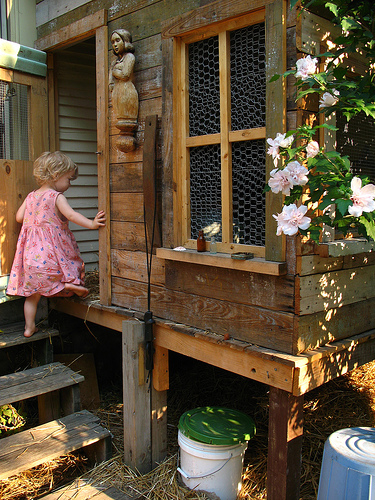

In [9]:
from IPython.display import Image
Image(filename = 'Flicker8k_Dataset/1000268201_693b08cb0e.jpg')

3. defining functions to map the text to images: 


In [10]:
from itertools import islice

def load_captions_data(filename):
  """loads captions data from text file and maps them to the correcponding image
  args: 
  filename- path to text file containing data
  returns: 
  caption mapping: dictionary mapping image and corresponding text (a list of all available captions for an image)"""

  # preprocessing of text file
  with open(filename) as caption_file:
    caption_data = caption_file.readlines()
    caption_mapping = {} #empty dict
    text_data = [] # we'll make a list
    images_to_skip = set()

    for line in caption_data:
      line = line.rstrip('\n') # removes all trailing characters
      img_name, caption = line.split('\t') # spilitting at tab space to separate image name and caption

      img_name = img_name.split('#')[0] # splitting at the # and taking 1st part
      img_name = os.path.join(IMAGES_PATH, img_name.strip()) # joining the path to name to get the complete path

      # captions splitting in tokens and removing too long or too short captions

      tokens = caption.strip().split()

      #print('tokens', tokens)

      if len(tokens)< 5 or len(tokens) > SEQ_LENGTH:
        images_to_skip.add(img_name) # adding to the set of images to skip
        continue

      if img_name.endswith('jpg') and img_name not in images_to_skip:
        caption = '<start>' + caption.strip() + '<end>'
        text_data.append(caption)

        if img_name in caption_mapping:
          caption_mapping[img_name].append(caption)
        else:
          caption_mapping[img_name] = [caption]

    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del(caption_mapping[img_name])


    print(dict(islice(caption_mapping.items(), 0, 2)))
    print(text_data[0:10])

    return caption_mapping, text_data





In [11]:
captions_mapping, txt_data = load_captions_data('Flickr8k.token.txt')

{'Flicker8k_Dataset/1000268201_693b08cb0e.jpg': ['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>', '<start>A girl going into a wooden building .<end>', '<start>A little girl climbing into a wooden playhouse .<end>', '<start>A little girl climbing the stairs to her playhouse .<end>', '<start>A little girl in a pink dress going into a wooden cabin .<end>'], 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg': ['<start>A black dog and a spotted dog are fighting<end>', '<start>A black dog and a tri-colored dog playing with each other on the road .<end>', '<start>A black dog and a white dog with brown spots are staring at each other in the street .<end>', '<start>Two dogs of different breeds looking at each other on the road .<end>', '<start>Two dogs on pavement moving toward each other .<end>']}
['<start>A child in a pink dress is climbing up a set of stairs in an entry way .<end>', '<start>A girl going into a wooden building .<end>', '<start>A little girl c

In [12]:
#captions_mapping, txt_data[0]

4. splitting the data in train and validation sets (test dataset is given)

In [12]:
def train_val_split(caption_data, train_size = 0.8, shuffle = True):

  """ split the caption data into train and validation set
        args:
          caption data(dict): dictionary containing the mapped caption data
          train_size: set as 80% for train data
          shuffle: True to shuffle the dataset before split

        returns: 
          training and validation datasets as 2 differnt dicts"""

  #1. get the list of all image names
  all_images = list(caption_data.keys())

  print(all_images[0:10])

  #2. shuffle if necessary
  if shuffle:
    np.random.shuffle(all_images)

  print('after shuffle', all_images[:10])

  #3. split into train and validation sets

  train_size = int(len(caption_data) * train_size)

  print(train_size)

  training_data = {
      img_name:caption_data[img_name] for img_name in all_images[:train_size]
        
  }
  validation_data = {
      img_name: caption_data[img_name] for img_name in all_images[train_size:]
  }

  return training_data, validation_data




In [13]:
train_data, val_data = train_val_split(captions_mapping)

['Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'Flicker8k_Dataset/1003163366_44323f5815.jpg', 'Flicker8k_Dataset/1007129816_e794419615.jpg', 'Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'Flicker8k_Dataset/1009434119_febe49276a.jpg', 'Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'Flicker8k_Dataset/1015118661_980735411b.jpg', 'Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']
after shuffle ['Flicker8k_Dataset/3459362347_c412ef9901.jpg', 'Flicker8k_Dataset/2080033499_6be742f483.jpg', 'Flicker8k_Dataset/506478284_7cf8bdbe36.jpg', 'Flicker8k_Dataset/861795382_5145ad433d.jpg', 'Flicker8k_Dataset/1342766791_1e72f92455.jpg', 'Flicker8k_Dataset/2192333873_2a0cbe849d.jpg', 'Flicker8k_Dataset/554774472_b5d165ff69.jpg', 'Flicker8k_Dataset/3700322513_50f0d45bfa.jpg', 'Flicker8k_Dataset/2860035355_3fe7a5caa4.jpg', 'Flicker8k_Dataset/2353088412_5e5804c6f5.jpg']
6114


In [14]:
print(list(train_data.keys())[:10])

['Flicker8k_Dataset/3459362347_c412ef9901.jpg', 'Flicker8k_Dataset/2080033499_6be742f483.jpg', 'Flicker8k_Dataset/506478284_7cf8bdbe36.jpg', 'Flicker8k_Dataset/861795382_5145ad433d.jpg', 'Flicker8k_Dataset/1342766791_1e72f92455.jpg', 'Flicker8k_Dataset/2192333873_2a0cbe849d.jpg', 'Flicker8k_Dataset/554774472_b5d165ff69.jpg', 'Flicker8k_Dataset/3700322513_50f0d45bfa.jpg', 'Flicker8k_Dataset/2860035355_3fe7a5caa4.jpg', 'Flicker8k_Dataset/2353088412_5e5804c6f5.jpg']


In [15]:
print('training size', len(train_data))
print('validation size', len(val_data))

training size 6114
validation size 1529


5. Further cleaning of text

In [16]:
def custom_standardization(input_string):
  print(type(input_string))
  lowercase = tf.strings.lower(input_string)
  print(type(lowercase))
  strip_chars = "~!@#$%^&*(){}_+:\"<>?,./;'[]-=" 
  strip_chars = strip_chars.replace("<", "")
  strip_chars = strip_chars.replace(">", "")
  return tf.strings.regex_replace(lowercase, '[%s]' % re.escape(strip_chars), "")



In [17]:
custom_standardization('uaysfdqw9td1/lKDM,hgcidywgff@T_42]kWEG{rg]0ggi}  IY2W0=8')

<class 'str'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


<tf.Tensor: shape=(), dtype=string, numpy=b'uaysfdqw9td1lkdmhgcidywgfft42kwegrg0ggi  iy2w08'>

5. vectorization of the string (There will be other versions too)

In [18]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
vectorization = TextVectorization(
    max_tokens = VOCAB_SIZE, 
    output_mode = 'int', 
    output_sequence_length = SEQ_LENGTH,
    standardize = custom_standardization
)
vectorization.adapt(txt_data)

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


In [ ]:
#vectorization.get_vocabulary() # printing vextorized text

6. image preprocesing

In [19]:
# image augmentation to get more data from the same image by flipping, rotating, slicing etc
image_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(0.2),
     layers.RandomContrast(0.3),]
)

In [20]:
# Decode and resize images

def decode_and_resize(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels = 3) # the image is converted into color channels
  img = tf.image.resize(img, IMAGE_SIZE) # resize images according to set image sizes...reduces pixels
  img = tf.image.convert_image_dtype(img, tf.float32) # converts data type to tf.float32
  # print(type(img))
  return img

def process_input(img_path, captions): # applies to images and captions both
  return decode_and_resize(img_path), vectorization(captions)

def make_dataset(images, captions):
  dataset = tf.data.Dataset.from_tensor_slices((images, captions)) # using tf.Datset method: from_tensor_slices
  # creates a dataset with a separate element for each row of the input tensor:
  dataset = dataset.shuffle(len(images)) # method to pick random images from a buffer size of the list all_images (containing all image names)
  dataset = dataset.map(process_input, num_parallel_calls = AUTOTUNE) # autotune called to adjust num_parallel calls, while map iterates the autotune function over dataset
  dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE) # creates batch size, chec for the text below for better explanation.
  return dataset

"When the GPU is working on forward / backward propagation on the current batch, we want the CPU to process the next batch of data so that it is immediately ready. As the most expensive part of the computer, we want the GPU to be fully used all the time during training. We call this consumer / producer overlap, where the consumer is the GPU and the producer is the CPU.

With tf.data, you can do this with a simple call to dataset.prefetch(1) at the end of the pipeline (after batching). This will always prefetch one batch of data and make sure that there is always one ready.

In some cases, it can be useful to prefetch more than one batch. For instance if the duration of the preprocessing varies a lot, prefetching 10 batches would average out the processing time over 10 batches, instead of sometimes waiting for longer batches.

To give a concrete example, suppose than 10% of the batches take 10s to compute, and 90% take 1s. If the GPU takes 2s to train on one batch, by prefetching multiple batches you make sure that we never wait for these rare longer batches."

I'm not quite sure how to determine processing time of each batch but that's the next step. If your batches are roughly taking the same amount of time to process then I believe prefetch(batch_size=1) should suffice as your GPU wouldn't be waiting for the cPU to finish processing a computationally expensive batch.

In [21]:
# new_img = decode_and_resize('Flicker8k_Dataset/1000268201_693b08cb0e.jpg')
# Image(new_img)

7. Making final training dataset

In [21]:
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))
val_dataset = make_dataset(list(val_data.keys()), list(val_data.values()))

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


8. training the image captioner:
this will consist of 3 models:
a. CNN used to extract image features
b. a TransformerEncoder to create a transformer-based encoding of the images
c. a TransformerDedoder to decode the encoded images from the output of encoder

In [22]:
def get_cnn_model():
  base_model = efficientnet.EfficientNetB0(
      input_shape = (*IMAGE_SIZE, 3), # * to unpack tuple
      include_top = False, 
      weights = 'imagenet', # takes pre-trained weights
  )
  # freeze the feature extractor
  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input, base_model_out)
  return cnn_model

In [26]:
from google.colab import files
uploaded = files.upload()

Saving attention.png to attention.png


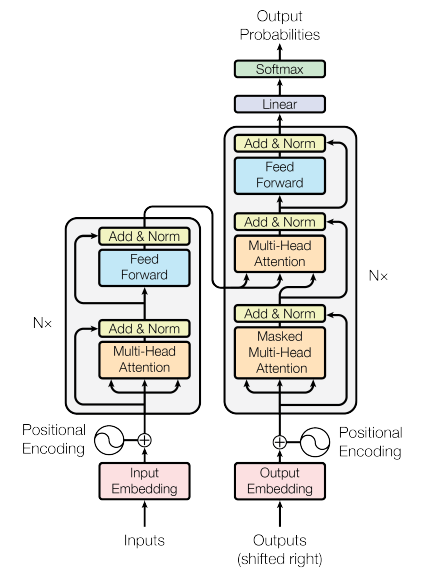

In [27]:
# attention is all we need
Image(filename = 'attention.png')

In [23]:
class TransformerEncoderBlock(layers.Layer): # transformer encoder with attention for semantic segmentation of images
# The Transformer allows for significantly more parallelization than a seq-to-seq/attention model for RNNs. Here it's used for images though....
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim # doesn't have a feed forward network
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention( #https://keras.io/api/layers/attention_layers/multi_head_attention/
        num_heads = num_heads, 
        key_dim = embed_dim, 
        dropout = 0.0
    )
    self.layernorm_1 = layers.LayerNormalization() # Add and norm https://keras.io/api/layers/normalization_layers/layer_normalization/
    # Normalize the activations of the previous layer for each given example in a batch independently, 
    #rather than across a batch like Batch Normalization. 
    #i.e. applies a transformation that maintains the mean activation within each 
    #example close to 0 and the activation standard deviation close to 1.
    self.layernorm_2 = layers.LayerNormalization()
    self.dense_1 = layers.Dense(embed_dim, activation = 'relu')

  def call(self, inputs, training, mask = None): # To "call" means to make a reference in your code to a function that is written elsewhere
    inputs = self.layernorm_1(inputs)
    inputs = self.dense_1(inputs)

    attention_outpout_1 = self.attention_1(
        query = inputs, #query, value and inputs are same, that makes it a self-attention 
        value = inputs, 
        key = inputs, 
        attention_mask = None,
        training = training,
    )
    out_1 = self.layernorm_2(inputs = attention_outpout_1)
    return out_1

In [24]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        #This layer can only be used on positive integer inputs of a fixed range. The tf.keras.layers.TextVectorization,
        # tf.keras.layers.StringLookup, and tf.keras.layers.IntegerLookup preprocessing layers can help prepare inputs for an Embedding layer.
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))# casting embed_dim as a new dtype and taking sqrt

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)# marking positions
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)# returns the truth value (True/False) x!=y element wise


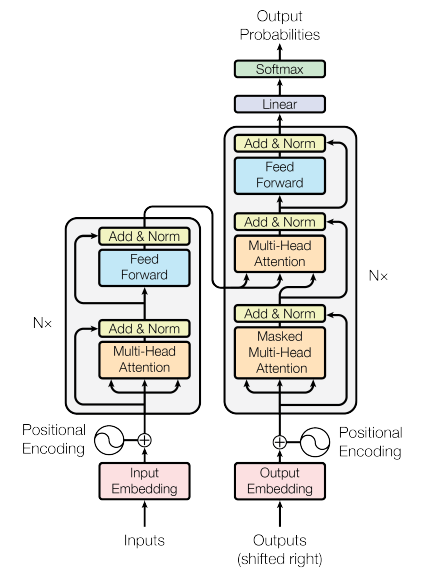

In [30]:
# attention is all we need
Image(filename = 'attention.png')

In [25]:
# https://keras.io/examples/nlp/text_classification_with_transformer/
class TransformerDecoderBlock(layers.Layer):
  def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.ff_dim = ff_dim # feed-forward network dim set as 512
    self.num_heads = num_heads
    self.attention_1 = layers.MultiHeadAttention(
        num_heads = num_heads,
        key_dim = embed_dim, 
        dropout = 0.1
    )
    self.attention_2 = layers.MultiHeadAttention(
        num_heads = num_heads,
        key_dim = embed_dim, 
        dropout = 0.1
    )
    self.ffn_layer_1 = layers.Dense(ff_dim, activation = 'relu')
    self.ffn_layer_2 = layers.Dense(embed_dim)

    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()
    self.layernorm_3 = layers.LayerNormalization()
    
    self.embedding = PositionalEmbedding(
        embed_dim = EMBED_DIM, 
        sequence_length = SEQ_LENGTH, 
        vocab_size = VOCAB_SIZE
    )

    self.out = layers.Dense(VOCAB_SIZE, activation = 'softmax')
    self.dropout_1 = layers.Dropout(0.3) # dropout to prevent overfitting
    self.dropout_2 = layers.Dropout(0.5)
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, training, mask = None):
    inputs = self.embedding(inputs)
    casual_mask = self.get_casual_attention_mask(inputs)

    if mask is not None: # masking is used to prevent the information to be used in the future
      padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype = tf.int32)
      combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype = tf.int32)
      combined_mask = tf.minimum(combined_mask, casual_mask)

    attention_output_1 = self.attention_1(
        query = inputs, 
        value = inputs, 
        key = inputs, 
        attention_mask = combined_mask, 
        training = training,
    )

    out_1 = self.layernorm_1(inputs + attention_output_1)

    attention_output_2 = self.attention_2(
        query = out_1, 
        value = encoder_outputs, 
        key = encoder_outputs,
        attention_mask = padding_mask, 
        training = training, 
    )
          
      
    out_2 = self.layernorm_2(out_1 + attention_output_2)
    ffn_out = self.ffn_layer_1(out_2)
    ffn_out = self.dropout_1(ffn_out, training = training)
    ffn_out = self.ffn_layer_2(ffn_out)
    ffn_out = self.layernorm_3(ffn_out + out_2, training = training)
    ffn_out = self.dropout_2(ffn_out, training = training)
    preds = self.out(ffn_out)
    return preds


  def get_casual_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i>= j, dtype = 'int32')
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype = tf.int32)], axis = 0
    )
          
    return tf.tile(mask, mult)

In [26]:
class ImageCaptioningModel(keras.Model):
    def __init__(
        self, cnn_model, encoder, decoder, num_captions_per_image=5, image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder, image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 2s 0us/step


9. bundling all models into caption_model

In [27]:
cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim = EMBED_DIM, dense_dim = FF_DIM, num_heads = 1)
decoder = TransformerDecoderBlock(embed_dim = EMBED_DIM, ff_dim = FF_DIM, num_heads = 2)
caption_model = ImageCaptioningModel(
    cnn_model = cnn_model, encoder = encoder, decoder = decoder, image_aug = image_augmentation,
)

10. train the model

In [28]:
# define loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits = False, reduction = 'none'
)

# early stopping critreria
early_stopping = keras.callbacks.EarlyStopping(patience = 3, restore_best_weights = True)

# learning rate scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, post_warmup_learning_rate, warmup_steps):
    super().__init__()
    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps
  def __call__(self, step):
    global_step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step/warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
    return tf.cond(
        global_step < warmup_steps,
        lambda: warmup_learning_rate,
        lambda: self.post_warmup_learning_rate,
    )

# create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate = 1e-4, warmup_steps = num_warmup_steps)

# compile the model
caption_model.compile(optimizer = keras.optimizers.Adam(lr_schedule), loss = cross_entropy)

# fit the model 
caption_model.fit(
    train_dataset,
    epochs = EPOCHS,
    validation_data = val_dataset,
    callbacks = [early_stopping],
)

Epoch 1/30
96/96 [==============================] - 101s 843ms/step - loss: 29.2602 - acc: 0.1053 - val_loss: 21.8148 - val_acc: 0.2771
Epoch 2/30
96/96 [==============================] - 67s 694ms/step - loss: 20.7334 - acc: 0.2821 - val_loss: 19.3762 - val_acc: 0.3137
Epoch 3/30
96/96 [==============================] - 67s 696ms/step - loss: 18.6708 - acc: 0.3202 - val_loss: 18.1682 - val_acc: 0.3354
Epoch 4/30
96/96 [==============================] - 66s 692ms/step - loss: 17.3895 - acc: 0.3459 - val_loss: 17.4367 - val_acc: 0.3485
Epoch 5/30
96/96 [==============================] - 65s 680ms/step - loss: 16.4559 - acc: 0.3636 - val_loss: 16.9421 - val_acc: 0.3581
Epoch 6/30
96/96 [==============================] - 67s 697ms/step - loss: 15.6736 - acc: 0.3780 - val_loss: 16.6465 - val_acc: 0.3660
Epoch 7/30
96/96 [==============================] - 66s 683ms/step - loss: 15.0305 - acc: 0.3946 - val_loss: 16.4489 - val_acc: 0.3712
Epoch 8/30
96/96 [==============================] - 67

In [34]:
#upload an image from disk:
from google.colab import files
uploaded = files.upload()

Saving tree_sun.jpeg to tree_sun.jpeg


In [35]:
image_1 = 'tree_sun.jpeg'

In [67]:
# from tensorflow.keras.applications.vgg16 import VGG16

# def get_cnn_model_2():
#   base_model = VGG16(
#       input_shape = (*IMAGE_SIZE, 3), # * to unpack tuple
#       include_top = False, 
#       weights = 'imagenet', # takes pre-trained weights
#   )
#   # freeze the feature extractor
#   base_model.trainable = False
#   base_model_out = base_model.output
#   base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
#   cnn_model_2 = keras.models.Model(base_model.input, base_model_out)
#   return cnn_model_2

In [78]:
# cnn_model_2 = get_cnn_model_2()
# caption_model_2 = ImageCaptioningModel(
#     cnn_model = cnn_model_2, encoder = encoder, decoder = decoder, image_aug = image_augmentation,
# )

In [ ]:
model_list = []

In [76]:
# # getting the image ready for captioning:
# vocab = vectorization.get_vocabulary()
# index_lookup = dict(zip(range(len(vocab)), vocab))
# max_decoded_sentence_length = SEQ_LENGTH - 1



# def generate_caption(sample_img):
    
#     # Read the image from the disk
#     sample_img = decode_and_resize(sample_img)
#     img = sample_img.numpy().clip(0, 255).astype(np.uint8)
#     plt.imshow(img)
#     plt.show()
# # generating caption 1: 
    
#     # Pass the image to the CNN-model-1
#     img1 = tf.expand_dims(sample_img, 0)
#     img1 = caption_model.cnn_model(img1)


#       # Pass the image features to the Transformer encoder
#     encoded_img1 = caption_model.encoder(img1, training=False)

#       # Generate the caption using the Transformer decoder
#     decoded_caption1 = "<start> "
#     for i in range(max_decoded_sentence_length):
#         tokenized_caption1 = vectorization([decoded_caption1])[:, :-1]
#         mask = tf.math.not_equal(tokenized_caption1, 0)
#         predictions1 = caption_model.decoder(
#             tokenized_caption1, encoded_img1, training=False, mask=mask
#         )
#         sampled_token_index1 = np.argmax(predictions1[0, i, :])
#         sampled_token1 = index_lookup[sampled_token_index1]
#         if sampled_token1 == " <end>":
#             break
#         decoded_caption1 += " " + sampled_token1

#     decoded_caption1 = decoded_caption1.replace("<start> ", "")
#     decoded_caption1 = decoded_caption1.replace(" <end>", "").strip()


#     # Pass the image to the CNN-model-2
#     img2 = tf.expand_dims(sample_img, 0)
#     img2 = caption_model_2.cnn_model_2(img2)


#       # Pass the image features to the Transformer encoder
#     encoded_img2 = caption_model_2.encoder(img2, training=False)

#       # Generate the caption using the Transformer decoder
#     decoded_caption2 = "<start> "
#     for i in range(max_decoded_sentence_length):
#         tokenized_caption2 = vectorization([decoded_caption2])[:, :-1]
#         mask = tf.math.not_equal(tokenized_caption2, 0)
#         predictions2 = caption_model.decoder(
#             tokenized_caption2, encoded_img2, training=False, mask=mask
#         )
#         sampled_token_index2 = np.argmax(predictions2[0, i, :])
#         sampled_token2 = index_lookup[sampled_token_index2]
#         if sampled_token2 == " <end>":
#             break
#         decoded_caption2 += " " + sampled_token2

#     decoded_caption2 = decoded_caption2.replace("<start> ", "")
#     decoded_caption2 = decoded_caption2.replace(" <end>", "").strip()

#     print("Predicted Caption 1: ", decoded_caption1, "Predicted Caption 2: ", decoded_caption2 )




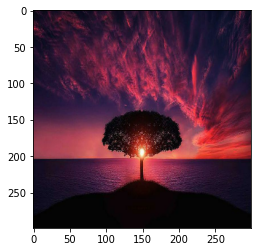

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.fr

AttributeError: ignored

In [77]:
generate_caption(image_1)

In [93]:
import random
import numpy as np

# getting the image ready for captioning:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab)) # vocabulary is indexed in a dictionary
max_decoded_sentence_length = SEQ_LENGTH

#cheating : adding random noise to image to generate different images

def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

def generate_caption(sample_img):
    
    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    for j in range(3):

      # Pass the image to the CNN
      img = add_noise(sample_img)
      img = tf.expand_dims(img, 0)
      img = caption_model.cnn_model(img)


      # Pass the image features to the Transformer encoder
      encoded_img = caption_model.encoder(img, training=False)

      # Generate the caption using the Transformer decoder
      decoded_caption = "<start> "
      for i in range(max_decoded_sentence_length):
        
        tokenized_caption = vectorization([decoded_caption])
        #print('tokenized caption :', tokenized_caption)
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
              tokenized_caption, encoded_img, training=False, mask=mask
          )
        sampled_token_index = np.argmax(predictions[0, i, :]) # returns the index of max value
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == " <end>":
            break
        decoded_caption += " " + sampled_token

      decoded_caption = decoded_caption.replace("<start> ", "")
      decoded_caption = decoded_caption.replace(" <end>", "").strip()
      print("Predicted Caption: ", decoded_caption)




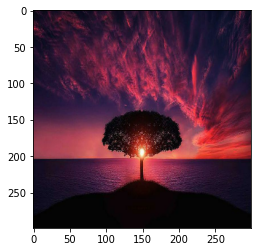

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.fr

In [94]:
# Check predictions for a few samples
generate_caption(image_1)
